### Importo las librerías necesarias para el proyecto

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical

### Empiezo hacer el modelo 1D (Tabular) — Sexo, Edad y Localización

* Asigno una semilla aleatoria para guardar la reproducibilidad de los resultados
* Tambien obtengo la ruta del dataset HAM10000_metadata
* Por ultimo leo el dataset con pandas y selecciono las columnas dx, sex, age y localization

In [2]:
np.random.seed(10)
tf.random.set_seed(10)

DATASET_DIR = "/Users/juandiego/Documents/study/keepcoding/deep_learning/datasets"
META_PATH = os.path.join(DATASET_DIR, "HAM10000_metadata.csv")

df = pd.read_csv(META_PATH)
df = df[["dx", "sex", "age", "localization"]].copy()

##### Verifico el numero de filas y columnas del dataset

In [3]:
print("Shape:", df.shape)

Shape: (10015, 4)


##### Verifico las clases posibles que aparecen en la columna dx del DataFrame.


In [4]:
print("Clases (dx):", sorted(df['dx'].unique()))

Clases (dx): ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


* Primero separo la variables X e Y del DataFrame
* Ahora divido el dataset en train, val y test


In [5]:
X = df[["sex", "age", "localization"]]
y = df["dx"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.30, random_state=42, stratify=y_train
)

In [6]:
print("Split -> train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)

Split -> train: (4907, 3) val: (2103, 3) test: (3005, 3)


#### Imputo los valores nulos de la columna age con la mediana de los valores de train

In [7]:
median_age = X_train['age'].median()
X_train['age'] = X_train['age'].fillna(median_age)
X_val['age'] = X_val['age'].fillna(median_age)
X_test['age'] = X_test['age'].fillna(median_age)

##### Creo un transformador que aplica One-Hot Encoding a las columnas categóricas sex, localization y Min-Max Scaling a la columna numérica age. Luego ajusto ese transformador con el train y transformo train, val y test con la misma configuración.

In [8]:
ct = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['sex', 'localization']),
        ('num', MinMaxScaler(), ['age'])
    ],
    remainder='drop'
)

ct.fit(X_train)
X_train_t = ct.transform(X_train)
X_val_t = ct.transform(X_val)
X_test_t = ct.transform(X_test)

#### cantidad de columnas resultaron despues de la transformacion.

In [9]:
feature_names = ct.get_feature_names_out()
print("Features transformadas:", len(feature_names))

Features transformadas: 19


#### Codifico las clases y a números con LabelEncoder y luego convierto esos números a one-hot vectors para que la red neuronal pueda entrenar en un problema multiclase.

In [10]:
le = LabelEncoder()
le.fit(y_train)
y_train_i = le.transform(y_train)
y_val_i = le.transform(y_val)
y_test_i = le.transform(y_test)
num_classes = len(le.classes_)
y_train_o = to_categorical(y_train_i, num_classes)
y_val_o = to_categorical(y_val_i, num_classes)
y_test_o = to_categorical(y_test_i, num_classes)

In [11]:
print("Clases:", list(le.classes_))

Clases: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [12]:
print("num_classes:", num_classes)

num_classes: 7


Creo una red neuronal usando como entrada las features transformadas, la compilo con Adam y entropía cruzada categórica, y la entreno con early stopping para evitar sobreajuste

In [13]:
input_dim = X_train_t.shape[1]
model = Sequential([
    Input(shape=(input_dim,)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.001
)

H = model.fit(
    X_train_t, y_train_o,
    validation_data=(X_val_t, y_val_o),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6739 - loss: 1.1427 - val_accuracy: 0.6909 - val_loss: 0.9837
Epoch 2/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - accuracy: 0.6968 - loss: 0.9490 - val_accuracy: 0.6961 - val_loss: 0.9392
Epoch 3/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - accuracy: 0.7012 - loss: 0.9218 - val_accuracy: 0.7004 - val_loss: 0.9245
Epoch 4/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - accuracy: 0.7006 - loss: 0.9101 - val_accuracy: 0.7000 - val_loss: 0.9181
Epoch 5/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - accuracy: 0.7014 - loss: 0.9026 - val_accuracy: 0.6976 - val_loss: 0.9145
Epoch 6/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - accuracy: 0.7025 - loss: 0.8964 - val_accuracy: 0.6981 - val_loss: 0.9133
Epoch 7/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - accuracy: 0.7035 - loss: 0.8921 - val_accuracy: 0.6976 - val_loss: 0.9129
Epoch 8/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.7035 - loss: 0.8

Grafica la pérdida de entrenamiento y validación a lo largo de las épocas, vemos que si esta aprendiendo bien y no hay sobreajuste.

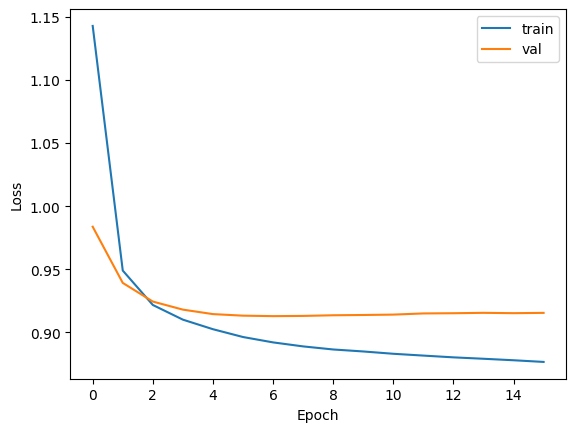

In [14]:
fig, ax = plt.subplots()
ax.plot(H.history['loss'], label='train')
ax.plot(H.history['val_loss'], label='val')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.show()

### Empiezo hacel el modelo 2D imágenes

Importo las librerías necesarias para el modelo 2D Imagenes

In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout

Igual que el modelo 1D, hago una semilla para reproducibilidad y cargo el dataset de imágenes

In [16]:
np.random.seed(10)
tf.random.set_seed(10)

DATASET_DIR = "/Users/juandiego/Documents/study/keepcoding/deep_learning/datasets"
IMG_PATH = os.path.join(DATASET_DIR, "hmnist_28_28_RGB.csv")
META_PATH = os.path.join(DATASET_DIR, "HAM10000_metadata.csv")

df_img = pd.read_csv(IMG_PATH)

Busca de dónde sacar la columna de etiquetas label - dx. Si ya viene en el DataFrame, la usa. Si no viene, intenta obtenerla cruzando el DataFrame con el archivo de metadata usando image_id. Si no encuentra ninguna etiqueta, lanza un error.

In [17]:
label_col = None
if 'label' in df_img.columns:
    label_col = 'label'
elif 'dx' in df_img.columns:
    label_col = 'dx'

if label_col is not None:
    y_raw = df_img[label_col]
    X_flat = df_img.drop(columns=[label_col, 'image_id'], errors='ignore').values
else:
    if 'image_id' in df_img.columns and os.path.exists(META_PATH):
        meta = pd.read_csv(META_PATH)[['image_id', 'dx']]
        dfm = df_img.merge(meta, on='image_id', how='inner')
        y_raw = dfm['dx']
        X_flat = dfm.drop(columns=['dx', 'image_id'], errors='ignore').values
    else:
        raise ValueError('No se pudo determinar las etiquetas en el DataFrame.')

Tomo los datos planos de las imágenes, calcula el tamaño de la imagen, y reconstruye las imágenes normalizándolas a valores entre 0 y 1.

In [18]:
n_samples = X_flat.shape[0]
n_features = X_flat.shape[1]
img_dim = int(np.sqrt(n_features // 3))
X_img = X_flat.reshape(n_samples, img_dim, img_dim, 3).astype('float32') / 255.0

Convierto las etiquetas en texto y_raw a números enteros y luego a formato one-hot para entrenar

In [19]:
le2d = LabelEncoder()
y_int = le2d.fit_transform(y_raw)
num_classes_2d = len(le2d.classes_)
y_onehot = to_categorical(y_int, num_classes_2d)

Imprime la forma del tensor de imágenes y la lista de clases del dataset.

In [20]:
print('Imágenes:', X_img.shape, '| Clases:', list(le2d.classes_))

Imágenes: (10015, 28, 28, 3) | Clases: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]


Divido las imágenes X_img y sus etiquetas one-hot, y_onehot en train, validation y test, usando estratificación para mantener el balance de clases

In [21]:
X_train2d, X_test2d, y_train2d, y_test2d = train_test_split(
    X_img, y_onehot, test_size=0.30, random_state=42, stratify=y_int
)
y_train_int2d = np.argmax(y_train2d, axis=1)
X_train2d, X_val2d, y_train2d, y_val2d = train_test_split(
    X_train2d, y_train2d, test_size=0.30, random_state=42, stratify=y_train_int2d
)

In [22]:
print('Split 2D -> train:', X_train2d.shape, 'val:', X_val2d.shape, 'test:', X_test2d.shape)

Split 2D -> train: (4907, 28, 28, 3) val: (2103, 28, 28, 3) test: (3005, 28, 28, 3)


Creo la red neuronal convolucional para clasificar las imágenes
* Primero defino la arquitectura de la red, aplique  una convulcion de 32 y el maxpooling para reducir la dimencionalidad, y un bloque de 64 para
que pueda aprender caracteristicas mas complejas, tambien agregue una capa de dropout para evitar overfitting, y una capa densa de 128 neuronas.
* Compilo el modelo, usando categorical crossentropy como función de pérdida y accuracy como métrica.
* Aplico early stopping para detener el entrenamiento cuando la pérdida de validación no mejore en 10 épocas.
* Entreno el modelo usando el conjunto de entrenamiento aumentado, y valido con el conjunto de validación.

In [23]:


model2d = Sequential([
    Input(shape=(img_dim, img_dim, 3)),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes_2d, activation='softmax')
])

model2d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early2d = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.001)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

datagen.fit(X_train2d)

H2d = model2d.fit(
    datagen.flow(X_train2d, y_train2d, batch_size=64),
    validation_data=(X_val2d, y_val2d),
    epochs=50,
    callbacks=[early2d],
    verbose=1
)


Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6631 - loss: 1.1288 - val_accuracy: 0.6695 - val_loss: 1.0192
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6707 - loss: 0.9896 - val_accuracy: 0.6700 - val_loss: 0.9236
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6729 - loss: 0.9379 - val_accuracy: 0.6700 - val_loss: 0.9002
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6733 - loss: 0.9120 - val_accuracy: 0.6790 - val_loss: 0.8669
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6778 - loss: 0.8949 - val_accuracy: 0.6881 - val_loss: 0.8666
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6813 - loss: 0.8718 - val_accuracy: 0.6800 - val_loss: 0.8755
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6762 - loss: 0.8768 - val_accuracy: 0.6771 - val_loss: 0.8457
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6807 - loss: 0.8564 - val_accuracy: 0.6885 - v

La grafica del entrenamiento se puede observar llega a un accuracy de 0.76, se logra notar que entre mas epocas va avanzando trata de hacer un overfitting, ya que la perdida de entrenamiento es menor que la de validacion, Por lo tanto el stop early se activa antes de llegar a la ultima epoca que seria 50.

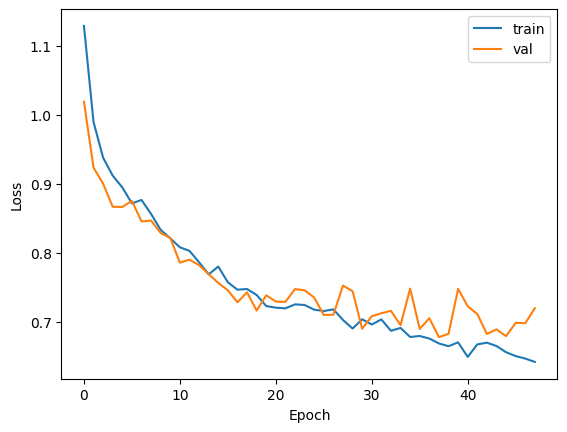

In [24]:
fig, ax = plt.subplots()
ax.plot(H2d.history['loss'], label='train')
ax.plot(H2d.history['val_loss'], label='val')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.show()

evaluación final del modelo usando el conjunto de prueba

In [25]:
test_pred2d = model2d.predict(X_test2d)
test_pred_i2d = np.argmax(test_pred2d, axis=1)
y_test_i2d = np.argmax(y_test2d, axis=1)
print('Matriz de confusión (test 2D):')
print(confusion_matrix(y_test_i2d, test_pred_i2d))

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Matriz de confusión (test 2D):
[[  40   27    5    0   18    0    8]
 [  17   89    5    0   32    3    8]
 [  21   24  116    0  133    1   35]
 [   3   13    3    0   11    1    3]
 [   5   26   37    0 1861    7   76]
 [   0    3    0    0   10   28    2]
 [   8    3   35    0  148    1  139]]


In [26]:
val_pred2d = model2d.predict(X_val2d)
val_pred_i2d = np.argmax(val_pred2d, axis=1)
y_val_i2d = np.argmax(y_val2d, axis=1)
print('Matriz de confusión (val 2D):')
print(confusion_matrix(y_val_i2d, val_pred_i2d))

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Matriz de confusión (val 2D):
[[  23   19    4    0   11    0   12]
 [  10   58    6    0   24    0   10]
 [  11   16   84    0   86    1   33]
 [   4   11    2    0    6    0    1]
 [  10   24   29    0 1290    5   50]
 [   0    2    1    0    5   21    1]
 [   8    7   14    0  108    1   95]]
